In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.tableau import Tableau_10

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45975,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:39783,Total threads: 4
Dashboard: /proxy/43471/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:34307,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'cmip6', 'reanalysis']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

# Figure 2

In [5]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [6]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

Calculate trends

In [7]:
uas_trends = {}
vas_trends = {}
for k in keys:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})

In [8]:
uas_trends_cmip = {}
vas_trends_cmip = {}
for k in model_keys:
    u = uas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends_cmip[k] = MK_class.compute()
    uas_trends_cmip[k] = uas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends_cmip[k] = MK_class.compute()
    vas_trends_cmip[k] = vas_trends_cmip[k].rename({'x':'lon', 'y':'lat'})

Calculate area for weighting

In [9]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [10]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))
    v_ave[k] = (vas_cmip[k].mean('time')*mask*area).sum('lat')/((area*mask).sum('lat'))

In [11]:
ut_ave = {}
vt_ave = {}
for k in keys:
    ut_ave[k] = (uas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
for k in model_keys:
    ut_ave[k] = (uas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))
    vt_ave[k] = (vas_trends_cmip[k]['trend']*mask*area).sum('lat')/((area*mask).sum('lat'))

In [12]:
u_ave_xarray = u_ave[model_keys[0]]
v_ave_xarray = v_ave[model_keys[0]]
for k in model_keys[1:]:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = model_keys
v_ave_xarray['model'] = model_keys

u_ave_cmip_sd = u_ave_xarray.sel(model = model_keys).std('model')
v_ave_cmip_sd = v_ave_xarray.sel(model = model_keys).std('model')

In [13]:
ut_ave_xarray = ut_ave[model_keys[0]]
vt_ave_xarray = vt_ave[model_keys[0]]
for k in model_keys[1:]:
    ut_ave_xarray = xr.concat([ut_ave_xarray, ut_ave[k]], dim = 'model')
    vt_ave_xarray = xr.concat([vt_ave_xarray, vt_ave[k]], dim = 'model')
ut_ave_xarray['model'] = model_keys
vt_ave_xarray['model'] = model_keys

ut_ave_cmip_sd = ut_ave_xarray.sel(model = model_keys).std('model')
vt_ave_cmip_sd = vt_ave_xarray.sel(model = model_keys).std('model')

In [14]:
import cmocean

In [15]:
legend_elements = [Line2D([0], [0], color = 'm', lw = 2, label = 'MRM'),
                   Line2D([0], [0], color = 'k', lw = 2, label = 'CMIP6 MMM'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

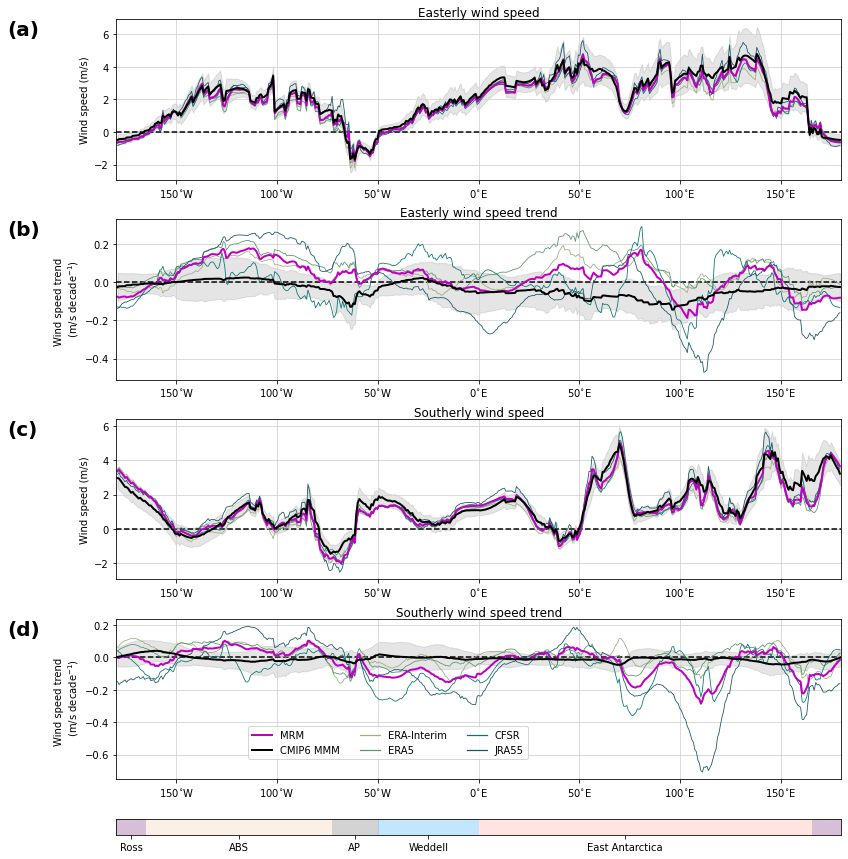

In [16]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (13, 15))
gr = gs.GridSpec(5, 1, figure = fig, hspace = .3, height_ratios = [1,1,1,1,.1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]),
       fig.add_subplot(gr[4,0])]
for ax, label in zip(axs, ['(a)', '(b)', '(c)', '(d)']):
    ax.text(-0.15, .9, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.grid(linestyle = '-', color = 'lightgrey')
    ax.axhline(y = 0, linestyle = '--', color = 'k')
    ax.set_xlim(-180, 180)
    ticks = ax.set_xticks([-150, -100, -50, 0, 50, 100, 150])
    ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                        '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
  
axs[0].set_ylabel('Wind speed (m/s)')
axs[1].set_ylabel('Wind speed trend \n (m/s decade$^{-1}$)')
axs[2].set_ylabel('Wind speed (m/s)')
axs[3].set_ylabel('Wind speed trend \n (m/s decade$^{-1}$)')
axs[0].set_title('Easterly wind speed', transform = axs[0].transAxes)
axs[1].set_title('Easterly wind speed trend', transform = axs[1].transAxes)
axs[2].set_title('Southerly wind speed', transform = axs[2].transAxes)
axs[3].set_title('Southerly wind speed trend', transform = axs[3].transAxes)

# Zonal
for k, cl in zip(keys[:-1], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(u_ave[k]['lon'], -u_ave[k], color = cl, linewidth = .8)
    axs[1].plot(ut_ave[k]['lon'], -10*ut_ave[k], color = cl, linewidth = .8)
axs[0].plot(u_ave['reanalysis']['lon'], -u_ave['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(u_ave['cmip6']['lon'], -u_ave['cmip6'], color = 'k', linewidth = 2)
axs[0].fill_between(u_ave['cmip6']['lon'], -u_ave['cmip6']+u_ave_cmip_sd, 
                   -u_ave['cmip6']-u_ave_cmip_sd, color = 'k', alpha = 0.1)

axs[1].plot(ut_ave['reanalysis']['lon'], -10*ut_ave['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(ut_ave['cmip6']['lon'], -10*ut_ave['cmip6'], color = 'k', linewidth = 2)
axs[1].fill_between(ut_ave['cmip6']['lon'], -10*(ut_ave['cmip6']+ut_ave_cmip_sd), 
                   -10*(ut_ave['cmip6']-ut_ave_cmip_sd), color = 'k', alpha = 0.1)

# Meridional
for k, cl in zip(keys[:-1], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[2].plot(v_ave[k]['lon'], v_ave[k], color = cl, linewidth = .8)
    axs[3].plot(vt_ave[k]['lon'], 10*vt_ave[k], color = cl, linewidth = .8)
axs[2].plot(v_ave['reanalysis']['lon'], v_ave['reanalysis'], color = 'm', linewidth = 2)
axs[2].plot(v_ave['reanalysis']['lon'], v_ave['cmip6'], color = 'k', linewidth = 2)
axs[2].fill_between(v_ave['cmip6']['lon'], v_ave['cmip6']-v_ave_cmip_sd, 
                    v_ave['cmip6']+v_ave_cmip_sd, color = 'k', alpha = 0.1)
axs[3].plot(vt_ave['reanalysis']['lon'], 10*vt_ave['reanalysis'], color = 'm', linewidth = 2)
axs[3].plot(vt_ave['cmip6']['lon'], 10*vt_ave['cmip6'], color = 'k', linewidth = 2)
axs[3].fill_between(vt_ave['cmip6']['lon'], 10*(vt_ave['cmip6']-vt_ave_cmip_sd), 
                    10*(vt_ave['cmip6']+vt_ave_cmip_sd), color = 'k', alpha = 0.1)

fig.legend(handles = legend_elements, ncol = 3, bbox_to_anchor = (.57, .23))

axs[4].set_xlim(-180, 180)
axs[4].set_yticks([])
axs[4].set_xticks([-172.5, -119, -61.5, -25, 72.5])
axs[4].set_xticklabels(['Ross', 'ABS', 'AP', 'Weddell', 'East Antarctica'])
axs[4].axvspan(-180, -165, color = 'thistle')
axs[4].axvspan(162, 180, color = 'thistle')
axs[4].axvspan(-165, -73, color = 'linen')
axs[4].axvspan(-73, -50, color = 'lightgrey')
axs[4].axvspan(-50, 0, color = 'lightskyblue', alpha = 0.5)
axs[4].axvspan(0, 165, color = 'mistyrose')

plt.savefig('../results/v6/fig2-nohotmodels.jpg', bbox_inches = 'tight', dpi = 800)

# Figure 3

In [17]:
uas_ssp85 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp85 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))
psl_ssp85 = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2015-01-01', '2100-01-01'))

In [18]:
u = uas_ssp85.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
uas_trends_ssp85 = MK_class.compute()
uas_trends_ssp85 = uas_trends_ssp85.rename({'x':'lon', 'y':'lat'})

v = vas_ssp85.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
vas_trends_ssp85 = MK_class.compute()
vas_trends_ssp85 = vas_trends_ssp85.rename({'x':'lon', 'y':'lat'})

In [19]:
psl_change_ssp85 = psl_ssp85.sel(time = slice('2090-01-01', '2100-01-01')).mean('time') - \
                   psl_ssp85.sel(time = slice('2015-01-01', '2025-01-01')).mean('time')

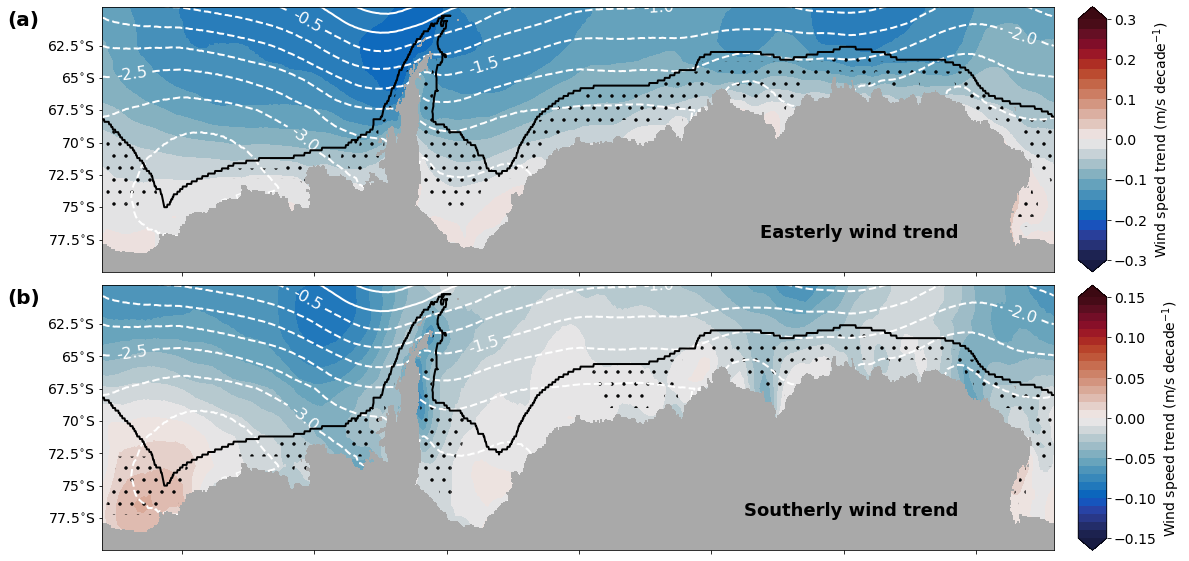

In [20]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]), fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)

axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

k = 'cmip6'
c = axs[0].contourf(uas_trends_ssp85['lon'], uas_trends_ssp85['lat'], -uas_trends_ssp85['trend']*10, 
                    levels = np.arange(-.3, .325, .025), extend = 'both', cmap = cmocean.cm.balance)
cbar = fig.colorbar(c, cax = axs[-2])
cbar.set_label('Wind speed trend (m/s decade$^{-1}$)')
cbar.set_ticks(np.arange(-.3, .4, .1))
axs[0].contourf(uas_trends_ssp85['lon'], uas_trends_ssp85['lat'], 
                xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*uas_trends_ssp85['p'].where(uas_trends_ssp85['p'] <= .05),
                colors = ['none'], hatches = ['.'])
c = axs[0].contour(psl_change_ssp85['lon'], psl_change_ssp85['lat'], psl_change_ssp85/100,
                   levels = np.arange(-5, 5.5, .5), colors = ['white'], linewidths = [2], zorder = 1)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)

c = axs[1].contourf(vas_trends_ssp85['lon'], vas_trends_ssp85['lat'], vas_trends_ssp85['trend']*10, 
                    levels = np.arange(-.15, .16, .01), extend = 'both', cmap = cmocean.cm.balance)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_label('Wind speed trend (m/s decade$^{-1}$)')
cbar.set_ticks(np.arange(-.15, .2, .05))
axs[1].contourf(vas_trends_ssp85['lon'], vas_trends_ssp85['lat'], 
                xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*vas_trends_ssp85['p'].where(vas_trends_ssp85['p'] <= .05),
                colors = ['none'], hatches = ['.'])
c = axs[1].contour(psl_change_ssp85['lon'], psl_change_ssp85['lat'], psl_change_ssp85/100,
                   levels = np.arange(-5, 5.5, .5), colors = ['white'], linewidths = [2], zorder = 1)
axs[1].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)

plt.savefig('../results/v6/fig3-nohotmodels.jpg', bbox_inches = 'tight', dpi = 800)

# Figure 4

In [29]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [30]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [31]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

Calculate area for weighting

In [32]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [33]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [34]:
u_ave_xarray = u_ave[model_keys[0]]
v_ave_xarray = v_ave[model_keys[0]]
for k in model_keys[1:]:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = model_keys
v_ave_xarray['model'] = model_keys

## SSP85

In [35]:
uas_ssp85 = {}; vas_ssp85 = {}
uas_ssp85['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas']
vas_ssp85['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp8.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp8.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp85[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp85[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [36]:
u_ave_ssp85 = {}
v_ave_ssp85 = {}
for k in ['cmip6']+model_keys:
    u_ave_ssp85[k] = (uas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp85[k] = (vas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [37]:
u_ave_xarray_ssp85 = u_ave_ssp85['cmip6']
v_ave_xarray_ssp85 = v_ave_ssp85['cmip6']
for k in model_keys:
    u_ave_xarray_ssp85 = xr.concat([u_ave_xarray_ssp85, u_ave_ssp85[k]], dim = 'model')
    v_ave_xarray_ssp85 = xr.concat([v_ave_xarray_ssp85, v_ave_ssp85[k]], dim = 'model')
u_ave_xarray_ssp85['model'] = ['cmip6']+model_keys
v_ave_xarray_ssp85['model'] = ['cmip6']+model_keys

In [38]:
u_sd_h = u_ave_xarray.sel(model = model_keys).std('model')
v_sd_h = v_ave_xarray.sel(model = model_keys).std('model')
u_sd_ssp85 = u_ave_xarray_ssp85.sel(model = model_keys).std('model')
v_sd_ssp85 = v_ave_xarray_ssp85.sel(model = model_keys).std('model')

## SSP45

In [39]:
uas_ssp45 = {}; vas_ssp45 = {}
uas_ssp45['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas']
vas_ssp45['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp4.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp4.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp45[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp45[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [40]:
u_ave_ssp45 = {}
v_ave_ssp45 = {}
for k in ['cmip6']+model_keys:
    u_ave_ssp45[k] = (uas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp45[k] = (vas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [41]:
u_ave_xarray_ssp45 = u_ave_ssp45['cmip6']
v_ave_xarray_ssp45 = v_ave_ssp45['cmip6']
for k in model_keys:
    u_ave_xarray_ssp45 = xr.concat([u_ave_xarray_ssp45, u_ave_ssp45[k]], dim = 'model')
    v_ave_xarray_ssp45 = xr.concat([v_ave_xarray_ssp45, v_ave_ssp45[k]], dim = 'model')
u_ave_xarray_ssp45['model'] = ['cmip6']+model_keys
v_ave_xarray_ssp45['model'] = ['cmip6']+model_keys

In [42]:
u_sd_h = u_ave_xarray.sel(model = model_keys).std('model')
v_sd_h = v_ave_xarray.sel(model = model_keys).std('model')
u_sd_ssp45 = u_ave_xarray_ssp45.sel(model = model_keys).std('model')
v_sd_ssp45 = v_ave_xarray_ssp45.sel(model = model_keys).std('model')

## Quantify trends

In [43]:
MK_class = Mann_Kendall_test(-u_ave_xarray, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_hist = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_hist = MK_class.compute()

In [44]:
MK_class = Mann_Kendall_test(-u_ave_xarray_ssp85, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_ssp85 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_ssp85, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_ssp85 = MK_class.compute()

In [45]:
MK_class = Mann_Kendall_test(-u_ave_xarray_ssp45, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_ssp45 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_ssp45, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_ssp45 = MK_class.compute()

In [46]:
u_re_concat = u_ave['cmip6']
v_re_concat = v_ave['cmip6']
for k in keys[:-1]:
    u_re_concat = xr.concat([u_re_concat, u_ave[k]], dim = 'model')
    v_re_concat = xr.concat([v_re_concat, v_ave[k]], dim = 'model')
u_re_concat['model'] = ['cmip6']+keys[:-1]
v_re_concat['model'] = ['cmip6']+keys[:-1]

MK_class = Mann_Kendall_test(-u_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
ut_re = MK_class.compute()
MK_class = Mann_Kendall_test(v_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
vt_re = MK_class.compute()

## Plot

In [47]:
keys

['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [48]:
legend_elements = [Line2D([0], [0], color = 'k', lw = 3, label = 'CMIP6 MMM historical period'),
                   Line2D([0], [0], color = cmocean.cm.balance(.2), lw = 3, label = 'CMIP6 MMM SSP245'),
                   Line2D([0], [0], color = cmocean.cm.balance(.8), lw = 3, label = 'CMIP6 MMM SSP585'),
                   Line2D([0], [0], color = 'm', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

In [49]:
ut_re['x']

<xarray.DataArray 'x' (x: 6)>
array(['cmip6', 'erai', 'era5', 'cfsr', 'jra55', 'reanalysis'], dtype='<U10')
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'

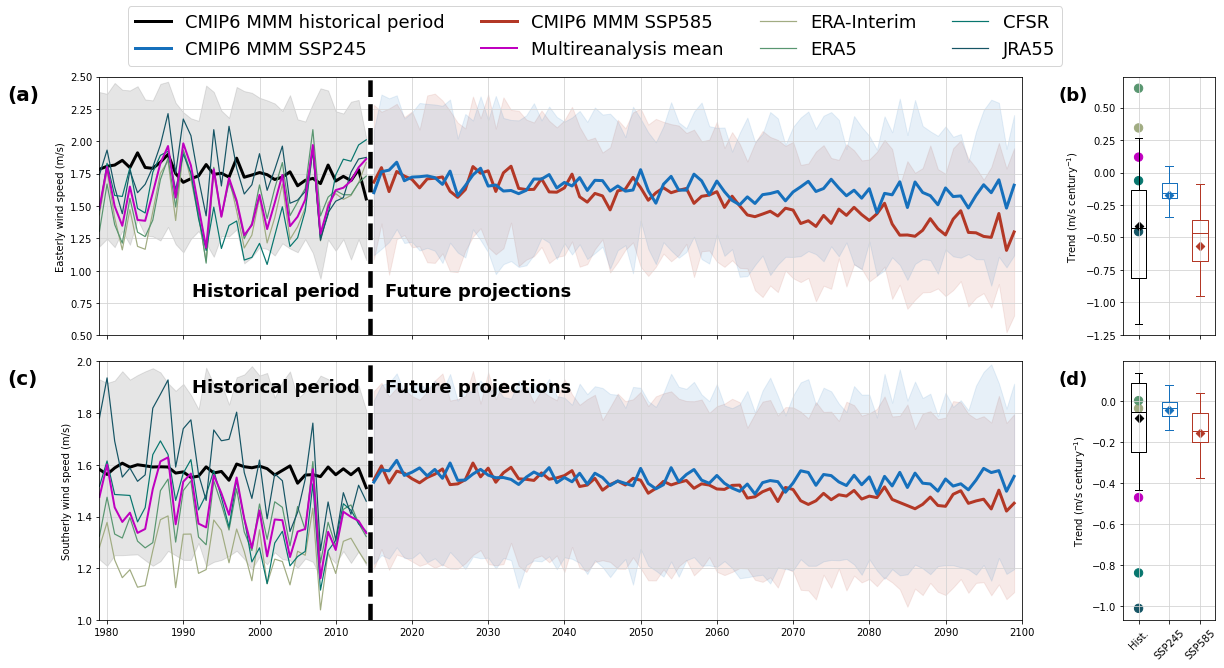

In [50]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, hspace = 0.1, width_ratios = [1, .1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['(a)', '(c)', '(b)', '(d)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.1, .91, label, transform = ax.transAxes, size = 20, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    else:
        ax.text(-0.7, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim(-.5, 2.5)

        
axs[0].plot(u_ave['cmip6']['year'], -u_ave['cmip6'], color = 'k', linewidth = 3)
axs[0].fill_between(u_ave['cmip6']['year'], -u_ave['cmip6']+u_sd_h, -u_ave['cmip6']-u_sd_h, 
                    color = 'k', alpha = 0.1)
axs[1].plot(v_ave['cmip6']['year'], v_ave['cmip6'], color = 'k', linewidth = 3)
axs[1].fill_between(v_ave['cmip6']['year'], v_ave['cmip6']-v_sd_h, v_ave['cmip6']+v_sd_h, 
                    color = 'k', alpha = 0.1)

for k, cl in zip(keys[:-2], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(u_ave[k]['year'], -u_ave[k], color = cl, linewidth = 1.2, label = k)
    axs[1].plot(v_ave[k]['year'], v_ave[k], color = cl, linewidth = 1.2, label = k)
    
axs[0].plot(u_ave['reanalysis']['year'], -u_ave['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(u_ave_ssp85['cmip6']['year'], -u_ave_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[0].fill_between(u_ave_ssp85['cmip6']['year'],-u_ave_ssp85['cmip6']+u_sd_ssp85, 
                    -u_ave_ssp85['cmip6']-u_sd_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[0].plot(u_ave_ssp45['cmip6']['year'], -u_ave_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[0].fill_between(u_ave_ssp45['cmip6']['year'],
                    -u_ave_ssp45['cmip6']+u_sd_ssp45, -u_ave_ssp45['cmip6']-u_sd_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[1].plot(v_ave['reanalysis']['year'], v_ave['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(v_ave_ssp85['cmip6']['year'], v_ave_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[1].fill_between(v_ave_ssp85['cmip6']['year'],v_ave_ssp85['cmip6']-v_sd_ssp85, 
                    v_ave_ssp85['cmip6']+v_sd_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[1].plot(v_ave_ssp45['cmip6']['year'], v_ave_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[1].fill_between(v_ave_ssp45['cmip6']['year'],
                    v_ave_ssp45['cmip6']-v_sd_ssp45, v_ave_ssp45['cmip6']+v_sd_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[0].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
axs[0].set_ylim(0.5, 2.5)
axs[1].set_ylim(1, 2)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Easterly wind speed (m/s)')
axs[1].set_ylabel('Southerly wind speed (m/s)')
axs[0].text(0.1, .15, 'Historical period', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[0].text(0.31, .15, 'Future projections', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.1, .88, 'Historical period', transform = axs[1].transAxes, size = 18, weight = 'bold')
axs[1].text(0.31, .88, 'Future projections', transform = axs[1].transAxes, size = 18, weight = 'bold')

axs[2].boxplot(ut_cmip_hist['trend']*100, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[2].boxplot(ut_cmip_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[2].boxplot(ut_cmip_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[2].scatter(np.zeros(5), ut_re['trend'].drop_sel(x = 'cmip6')*100, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[2].scatter(0, ut_re['trend'].sel(x = 'cmip6')*100, c = 'k', marker = 'D')
axs[2].scatter(1, ut_cmip_ssp45['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.2))
axs[2].scatter(2, ut_cmip_ssp85['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.8))

axs[3].boxplot(vt_cmip_hist['trend']*100, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[3].boxplot(vt_cmip_ssp45.drop_sel(x = 'cmip6')['trend']*100, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[3].boxplot(vt_cmip_ssp85.drop_sel(x = 'cmip6')['trend']*100, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[3].scatter(np.zeros(5), vt_re['trend'].drop_sel(x = 'cmip6')*100, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[3].scatter(0, vt_re['trend'].sel(x = 'cmip6')*100, c = 'k', marker = 'D')
axs[3].scatter(1, vt_cmip_ssp45['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.2))
axs[3].scatter(2, vt_cmip_ssp85['trend'].sel(x = 'cmip6')*100, marker = 'D', color = cmocean.cm.balance(.8))

axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels([])
axs[3].set_xticks([0,1,2])
axs[3].set_xticklabels(['Hist.', 'SSP245', 'SSP585'], rotation = 45)
axs[2].set_ylabel('Trend (m/s century$^{-1}$)')
axs[3].set_ylabel('Trend (m/s century$^{-1}$)')

fig.legend(handles = legend_elements, ncol = 4, fontsize = 18, bbox_to_anchor = (0.8, .99))

plt.savefig('../results/v6/fig4-nohotmodels.jpg', bbox_inches = 'tight', dpi = 800)